In [385]:
import numpyro
from jax import numpy as jnp, random, vmap
from jax.random import PRNGKey as PK
from numpyro.infer import Predictive
from numpyro.infer.mcmc import MCMC
from numpyro.infer.hmc import NUTS
from numpyro import sample, plate
from numpyro.handlers import seed
from numpyro import distributions as dist, handlers
import arviz as az
import pandas as pd
import seaborn as sns
from functools import partial
from sklearn import linear_model

# from numpyro import 

In [157]:
df = pd.read_csv('lenght_weight.csv')
df["sex_int"] = (df.sex == 'boy').astype(int)

In [101]:
sex_boy = jnp.asarray(df.sex == 'boy', dtype=jnp.int32)
length = jnp.asarray(df.length)
weight = jnp.asarray(df.weight)
X_all = jnp.stack((length, weight), 1)
print(X_all.shape)

(2000, 2)


In [87]:
mus = jnp.stack((jnp.diag(jnp.ones(2)), jnp.diag(jnp.ones(2))), 0)

In [90]:
mus

Array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]], dtype=float32)

In [315]:
def model_isotropic(X=None, sex_boy=None):
    with plate('sexes', 2):
        mu0 = sample('mu0', dist.Normal(0, 100))
        mu1 = sample('mu1', dist.Normal(0, 100))
        s = sample('s', dist.Exponential(10.))

    mu0s = mu0[sex_boy]
    mu1s = mu1[sex_boy]
    mu = jnp.stack((mu0s, mu1s), axis=-1)
    sigma = s * jnp.diag(jnp.ones(2))

    with plate('plate_obs', sex_boy.shape[0]):
        X_hat = sample('obs', dist.MultivariateNormal(mu, sigma), obs=X)
        return X_hat


def model_full(X=None, sex_boy=None):
    with plate('sexes', 2):
        mu0 = sample('mu0', dist.Normal(0, 100))
        mu1 = sample('mu1', dist.Normal(0, 100))
        s0 = sample('s0', dist.Exponential(10.))
        s1 = sample('s1', dist.Exponential(10.))
        rho = sample('rho', dist.Uniform(-1,1))

    mu0s = mu0[sex_boy]
    mu1s = mu1[sex_boy]
    mu = jnp.stack((mu0s, mu1s), axis=-1)

    # sigma
    sigmas = jnp.array([
        [[s0[0],rho[0]],[rho[0],s1[0]]],
        [[s0[1],rho[1]],[rho[1],s1[1]]]
    ])
    # s0s = s0[sex_boy]
    # s1s = s1[sex_boy]
    sigma = sigmas[sex_boy]
    # print(sigma.shape)
    
    with plate('plate_obs', sex_boy.shape[0]):
        # mu = mus[sex_boy]
        # sigma = jnp.where(sex_boy, sigma_boy, sigma_girl)
        X_hat = sample('obs', dist.MultivariateNormal(mu, sigma), obs=X)
        return X_hat

In [316]:
with seed(rng_seed=123):
    X_out = model_isotropic(X_all, jnp.astype(sex_boy, jnp.int32))
    X_out = model_full(X_all, jnp.astype(sex_boy, jnp.int32))

    print(X_out.shape)

(2000, 2)


In [314]:
mcmc_key = PK(1234)
models = {'isotropic': model_isotropic, 'full': model_full}
mcmcs = {k:MCMC(NUTS(model), num_warmup=100, num_samples=400, num_chains=4) for k, model in models.items()}

for k, mcmc in mcmcs.items():
    key, mcmc_key = random.split(mcmc_key, 2)
    mcmc.run(mcmc_key, X_all, sex_boy)
# samples_iso = mcmc.get_samples()

/var/folders/kv/br6bm8dd2m72m9t7s1dvykgw0000gq/T/ipykernel_84864/1870254831.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmcs = {k:MCMC(NUTS(model), num_warmup=100, num_samples=400, num_chains=4) for k, model in models.items()}


(2,)
(2000,)
(2,)
(2000,)


  0%|                                                                                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

(2,)
(2000,)


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 346.59it/s, 7 steps of size 5.54e-01. acc. prob=0.92]


(2,)
(2000,)
(2,)
(2000,)


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3374.48it/s, 3 steps of size 9.70e-01. acc. prob=0.85]


(2,)
(2000,)
(2,)
(2000,)


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3222.75it/s, 7 steps of size 5.73e-01. acc. prob=0.95]


(2,)
(2000,)
(2,)
(2000,)


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3252.37it/s, 7 steps of size 6.75e-01. acc. prob=0.92]


(2000, 2, 2)
(2000, 2, 2)
(2000, 2, 2)


  0%|                                                                                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

(2000, 2, 2)


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.82it/s, 7 steps of size 7.81e-03. acc. prob=0.97]


(2000, 2, 2)
(2000, 2, 2)
(2000, 2, 2)


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.52it/s, 63 steps of size 1.30e-02. acc. prob=0.80]


(2000, 2, 2)
(2000, 2, 2)


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.54it/s, 511 steps of size 5.51e-03. acc. prob=0.97]


(2000, 2, 2)
(2000, 2, 2)


sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.19it/s, 191 steps of size 8.05e-03. acc. prob=0.96]


In [317]:
smps = {k: mcmc.get_samples() for k, mcmc in mcmcs.items()}

In [322]:
smps['full']

{'mu0': Array([[0.9869392 , 2.115347  ],
        [0.93496054, 2.0831432 ],
        [0.99030745, 2.0832715 ],
        ...,
        [0.98088   , 2.0172522 ],
        [0.97248   , 2.022586  ],
        [0.97204214, 2.092778  ]], dtype=float32),
 'mu1': Array([[0.6231724 , 2.6466455 ],
        [0.58662015, 2.608571  ],
        [0.5808599 , 2.5785112 ],
        ...,
        [0.5871657 , 2.5240452 ],
        [0.5877132 , 2.5335586 ],
        [0.5995113 , 2.6081865 ]], dtype=float32),
 'rho': Array([[0.5347645 , 0.92719483],
        [0.52828455, 0.87893903],
        [0.52852833, 0.87306905],
        ...,
        [0.5837885 , 0.9514116 ],
        [0.5806422 , 0.95236826],
        [0.5508629 , 0.9688449 ]], dtype=float32),
 's0': Array([[0.90297323, 0.90525156],
        [0.8905472 , 0.85593605],
        [0.89652085, 0.8606665 ],
        ...,
        [0.93863964, 0.9405238 ],
        [0.9425169 , 0.93283135],
        [0.90143895, 0.96720004]], dtype=float32),
 's1': Array([[0.40667737, 1.0407908 

In [324]:
az.summary(mcmcs['full'])

(2000, 2, 2)
(2000, 2, 2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0[0],0.999,0.030,0.937,1.052,0.001,0.001,875.0,754.0,1.00
mu0[1],2.062,0.029,2.013,2.116,0.001,0.001,1521.0,1135.0,1.00
mu1[0],0.608,0.021,0.565,0.646,0.001,0.001,901.0,919.0,1.00
mu1[1],2.572,0.030,2.515,2.624,0.001,0.001,1597.0,1131.0,1.00
rho[0],0.563,0.026,0.511,0.609,0.001,0.001,384.0,521.0,1.01
rho[1],0.912,0.038,0.846,0.985,0.002,0.002,258.0,232.0,1.03
s0[0],0.917,0.040,0.846,0.996,0.002,0.001,421.0,497.0,1.01
s0[1],0.904,0.037,0.836,0.972,0.002,0.002,260.0,303.0,1.03
s1[0],0.439,0.019,0.401,0.472,0.001,0.001,416.0,560.0,1.01
s1[1],1.009,0.041,0.927,1.079,0.002,0.002,274.0,318.0,1.03


In [325]:
az.summary(mcmcs['isotropic'])

(2,)
(2000,)
(2,)
(2000,)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0[0],0.999,0.031,0.941,1.056,0.001,0.0,3066.0,1143.0,1.00
mu0[1],2.062,0.030,2.001,2.112,0.001,0.0,2226.0,1250.0,1.00
mu1[0],0.609,0.027,0.559,0.658,0.000,0.0,2865.0,1170.0,1.00
mu1[1],2.572,0.026,2.527,2.624,0.000,0.0,2943.0,1240.0,1.00
s[0],0.929,0.028,0.879,0.982,0.001,0.0,2378.0,986.0,1.00
s[1],0.742,0.022,0.700,0.783,0.000,0.0,2327.0,1131.0,1.01


In [326]:
# azds = {k: az.from_numpyro(mcmc) for k, mcmc in mcmcs.items()}
# azds = {k: az.from_dict(smp) for k, smp in smps.items()}
# azs = {k: az.summary(azd) for k, azd in azd.items()}
# azd = az.from_numpyro(mcmc)
# azs = az.summary(azd)

In [327]:
def predictive_sample(rng_key, post_sample, model, obs_site="obs", *args, **kwargs):
    model = seed(handlers.condition(model, post_sample), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace[obs_site]["value"]


# pred_iso1 = partial(predictive_sample, model=model_isotropic)
# pred_iso = vmap(lambda rng_key, post_sample, num_samples: vmap(lambda key: partial(pred_iso1, post_sample=post_sample, **kwargs))(random.split(rng_key, num_samples))
def pred_iso(rng_key, post_sample, num_samples, *args, **kwargs):
    keys = random.split(rng_key, num_samples)
    pred1 = partial(predictive_sample, post_sample=post_sample, model=model_isotropic)
    
    return vmap(lambda key: pred1(key, *args, **kwargs))(keys)

def pred_full(rng_key, post_sample, num_samples, *args, **kwargs):
    keys = random.split(rng_key, num_samples)
    pred1 = partial(predictive_sample, post_sample=post_sample, model=model_full)
    
    return vmap(lambda key: pred1(key, *args, **kwargs))(keys)

# def pred_iso(rng_key, num_samples=1):
    # keys = random.split(


# def predict_iso(rng_key, post_sample, num_samples=1, *args, **kwargs):
    # keys = random.split(rng_key, num_samples)
    # return vmap(lambda key: predict_sample(key, post_sample, model_isotropic)(*args, **kwargs)))(keys)


In [355]:
pred_key = PK(12345)
num_pred = int(1e4)
smps_bar = {model_tag: {k: jnp.mean(v, axis=0) for k, v in smp.items()} for model_tag, smp in smps.items()}
# smp_iso_bar = {k: jnp.mean(v, axis=0) for k,v in samples_iso.items()}
# smp_iso_bar = {k: jnp.mean(v, axis=0) for k,v in samples_iso.items()}
# predictive_iso = Predictive(model_isotropic, smp_iso_bar, num_samples=1000)
# preds_iso = predictive_iso(pred_key, sex_boy=jnp.array((0,1), dtype=jnp.int32))["X_obs"]
# preds_iso = pred_iso(pred_key, smp_iso_bar, num_pred, sex_boy=jnp.arange(2))
# print(preds_iso.shape)
preds_iso = pred_iso(pred_key, smps_bar['isotropic'], num_pred, sex_boy=jnp.arange(2))
preds_full = pred_full(pred_key, smps_bar['full'], num_pred, sex_boy=jnp.arange(2))

In [356]:
# smp_iso_map

In [357]:
df_iso0 = pd.DataFrame(preds_iso[:,0,:], columns=['length', 'weight'])
df_iso0['sex'] = "girl"
df_iso1 = pd.DataFrame(preds_iso[:,1,:], columns=['length', 'weight'])
df_iso1['sex'] = "boy"
df_iso = pd.concat((df_iso0, df_iso1))
df_iso["model"] = "isotropic"
# df_iso.columns = [

df_full0 = pd.DataFrame(preds_full[:,0,:], columns=['length', 'weight'])
df_full0['sex'] = "girl"
df_full1 = pd.DataFrame(preds_full[:,1,:], columns=['length', 'weight'])
df_full1['sex'] = "boy"
df_full = pd.concat((df_full0, df_full1))
df_full["model"] = "full"


In [358]:
df["model"] = "observed"

In [359]:
dfa = pd.concat((df, df_iso, df_full))
dfa["sex_int"] = (dfa.sex=='boy').astype(int)

In [360]:
# dfa

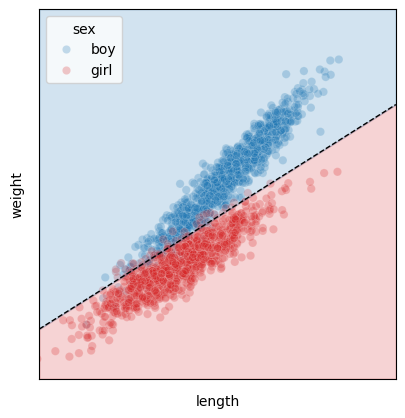

In [398]:
palette = {'boy': 'tab:blue', 'girl': 'tab:red'}
xmin, xmax = -2.2, 6
ymin, ymax = -2, 6.5

ax = sns.scatterplot(dfa[(dfa.model=='observed')], x='length', y='weight', hue='sex', palette=palette, alpha=0.25)
# ax = sns.scatterplot(dfa[(dfa.model=='observed')&(dfa.sex=='boy')], x='length', y='weight', hue='sex', palette=palette, alpha=0.25)
# ax = sns.scatterplot(dfa[(dfa.model=='observed')&(dfa.sex=='girl')], x='length', y='weight', hue='sex', palette=palette, alpha=0.25)
# ax = sns.kdeplot(dfa[dfa.model=='isotropic'], x='length', y='weight', hue='sex', palette=palette, levels=4)
# ax = sns.kdeplot(dfa[(dfa.model=='full')], x='length', y='weight', hue='sex', palette=palette, levels=4)
# ax = sns.kdeplot(dfa[(dfa.model=='full')&(dfa.sex=='girl')], x='length', y='weight', hue='sex', palette=palette, levels=4)
# ax = sns.kdeplot(dfa[(dfa.model=='full')&(dfa.sex=='boy')], x='length', y='weight', hue='sex', palette=palette, levels=4)


# Fit the data to a logistic regression model.
clf = linear_model.LogisticRegression()
clf.fit(X_all, sex_boy)

# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xd = jnp.array([xmin, xmax])
yd = m*xd + c
ax.plot(xd, yd, 'k', lw=1, ls='--')
ax.fill_between(xd, yd, ymin, color='tab:red', alpha=0.2)
ax.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)

ax.set_aspect("equal")
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

fig = ax.get_figure()
fig.savefig('class_logistic.pdf')